# HSE RLMS Dataset

### Code base
https://www.hse.ru/en/rlms/code

### Source data

https://www.hse.ru/en/rlms/downloads

In [1]:
# read data
import pandas as pd

model_config = {
    'target': 'j10',
    'gender': 'h5',
    'features': ['age', 'cc_educ', 'cc_diplom', 'ccj161_3y', 'ccj161_3m', 
                 'cc_occup08', 'ccj6_2', 'ccj11', 'ccj11_1', 'ccj21a', 'ccj4_1', 
                 'ccj23', 'ccj6', 'cc_marst', 'ccj1']
}

features = ['age', 'educ', 'diplom', 'j161_3y', 'j161_3m', 'occup08', 
            'j6_2', 'j11', 'j11_1', 'j21a', 'j4_1', 'j23', 'j6', 
            'marst', 'j1']
target = 'j10'

df = pd.read_stata("data/RLMS_IND_1994_2024_eng.dta", convert_categoricals=False, convert_dates=False, convert_missing=False)

In [31]:
df = df[features + ["j10", "h5"]]

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

In [39]:
MISSING_CODES = [99999999.0, 99999998.0, 99999997.0]

df_clean = df.copy()

# Removing impossible ages (< 15)
df_clean = df_clean[df_clean['age'] >= 15]

# Removing omissions in the target variable (j10 - salary)
df_clean = df_clean[df_clean['j10'].notna()]

# Removing absence codes
df_clean = df_clean[~df_clean['j10'].isin(MISSING_CODES)]

# Outlier removal (1%-99% quantile)
q1, q99 = df_clean['j10'].quantile([0.01, 0.99])
df_clean = df_clean[(df_clean['j10'] >= q1) & (df_clean['j10'] <= q99)]

# log(target) (for better interpretation in a linear model)
df_clean['log_j10'] = np.log(df_clean['j10'])

# Gender variable: 0 = male, 1 = female
df_clean['female'] = (df_clean['h5'] == 2).astype(int)

# Removing absence codes in other variables
for col in ['diplom', 'occup08', 'marst']:
    df_clean = df_clean[~df_clean[col].isin(MISSING_CODES)]

features = ['log_j10', 'j10', 'female', 'age', 'educ', 'diplom', 
            'occup08', 'marst', 'j1']
df_work = df_clean[features].dropna()

In [43]:
print("\nDistribution by gedner:")
males = (df_work['female'] == 0).sum()
females = (df_work['female'] == 1).sum()
print(f"  Males: {males} ({males/len(df_work)*100:.1f}%)")
print(f"  Females: {females} ({females/len(df_work)*100:.1f}%)")

# Average wages by gender
print("\nAverage salary by gender:")
wages_by_gender = df_work.groupby('female')['j10'].agg(['mean', 'median', 'std'])
wages_by_gender.index = ['Males', 'Females']
print(wages_by_gender.round(0))

# gender gap in wages
gap_abs = df_work[df_work['female']==0]['j10'].mean() - \
          df_work[df_work['female']==1]['j10'].mean()
gap_pct = gap_abs / df_work[df_work['female']==0]['j10'].mean() * 100
print(f"\nGender gap: {gap_abs:.0f} rubbles ({gap_pct:.1f}%)")


Distribution by gedner:
  Males: 83334 (46.9%)
  Females: 94249 (53.1%)

Average salary by gender:
            mean   median      std
Males    36810.0  20000.0  72333.0
Females  28848.0  14500.0  65145.0

Gender gap: 7962 rubbles (21.6%)


# Oaxaca-Blinder Decomposition for Gender Wage Gap Analysis

## What is This Model?

The **Oaxaca-Blinder decomposition** is a statistical method that breaks down the difference in outcomes (like wages) between two groups into explained and unexplained components. It answers the crucial question: *"How much of the wage gap between men and women is due to different characteristics versus different returns to those characteristics?"*

## Why This Matters

- **Identify potential discrimination**: Separates differences due to qualifications from differences due to potentially discriminatory pay structures
- **Guide policy decisions**: Shows where interventions would be most effective
- **Beyond simple statistics**: Provides deeper insight than raw wage gap numbers

## The Mathematical Framework

### Step 1: Separate Wage Equations

We estimate separate regression models for each group:

**For men:**
$$
\text{Wage}_m = \alpha_m + \beta_{m1}\text{Education} + \beta_{m2}\text{Experience} + \cdots + \epsilon_m
$$

**For women:**
$$
\text{Wage}_w = \alpha_w + \beta_{w1}\text{Education} + \beta_{w2}\text{Experience} + \cdots + \epsilon_w
$$

### Step 2: Calculate Total Wage Gap
$$
\text{Total Gap} = \bar{\text{Wage}}_m - \bar{\text{Wage}}_w
$$

### Step 3: The Core Decomposition

The magic happens here - we split the total gap:

$$
\text{Total Gap} = [\underbrace{(\bar{X}_m - \bar{X}_w)\hat{\beta}_m}_{\text{Explained}}] + [\underbrace{\bar{X}_w(\hat{\beta}_m - \hat{\beta}_w) + (\hat{\alpha}_m - \hat{\alpha}_w)}_{\text{Unexplained}}]
$$

Where:
- $\bar{X}_m$, $\bar{X}_w$ = mean characteristics for men and women
- $\hat{\beta}_m$, $\hat{\beta}_w$ = coefficient estimates from regressions
- $\hat{\alpha}_m$, $\hat{\alpha}_w$ = intercept terms

## Interpreting the Results

**Explained Component**: Wage gap due to differences in observable characteristics (education, experience, etc.)

**Unexplained Component**: Wage gap due to different returns to the same characteristics (potentially discrimination, but could also include unobserved factors)

## Key Insight

This method allows us to move from "there is a wage gap" to understanding "why there is a wage gap" - a crucial distinction for meaningful analysis and policy recommendations.

In [45]:
males = df_work[df_work['female'] == 0]
females = df_work[df_work['female'] == 1]

feature_cols = ['age', 'educ', 'diplom', 'occup08', 'marst', 'j1']

X_male = sm.add_constant(males[feature_cols])
y_male = males['log_j10']

X_female = sm.add_constant(females[feature_cols])
y_female = females['log_j10']

model_male = sm.OLS(y_male, X_male).fit()
model_female = sm.OLS(y_female, X_female).fit()

print("\nMales regression:")
print(model_male.summary2())

print("\nFemales regression:")
print(model_female.summary2())


Males regression:
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.132      
Dependent Variable: log_j10          AIC:                253485.6668
Date:               2025-11-12 16:21 BIC:                253550.9810
No. Observations:   83334            Log-Likelihood:     -1.2674e+05
Df Model:           6                F-statistic:        2112.      
Df Residuals:       83327            Prob (F-statistic): 0.00       
R-squared:          0.132            Scale:              1.2261     
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const        8.7561     0.0383   228.7447   0.0000    8.6810    8.8311
age         -0.0065     0.0003   -20.2931   0.0000   -0.0072   -0.0059
educ         0.0000     0.0000     3.2460   0.0012    0.0000    0.0000
diplom       0.1631   

In [46]:
beta_male = model_male.params
beta_female = model_female.params

X_male_mean = X_male.mean()
X_female_mean = X_female.mean()

y_male_mean = y_male.mean()
y_female_mean = y_female.mean()

total_gap = y_male_mean - y_female_mean

explained_gap = beta_male @ (X_male_mean - X_female_mean)
unexplained_gap = (beta_male - beta_female) @ X_female_mean

print("\n" + "="*80)
print("OAXACA-BLINDER DECOMPOSITION")
print("="*80)

print(f"\nTotal difference in log(salary): {total_gap:.4f}")
print(f"  = Explicable part (characteristics): {explained_gap:.4f} ({explained_gap/total_gap*100:.1f}%)")
print(f"  + Inexplicable part (coefficients): {unexplained_gap:.4f} ({unexplained_gap/total_gap*100:.1f}%)")

print(f"\nPercents:")
print(f"  Total salary difference: {(np.exp(total_gap)-1)*100:.2f}%")
print(f"  Because of the characteristics: {explained_gap*100:.2f} пункта")
print(f"  Because to the coefficients (unexplained): {unexplained_gap*100:.2f} пункта")


print("\n" + "="*80)
print("COMPONENTS OF THE EXPLICABLE PART BY VARIABLES")
print("="*80)

explained_components = beta_male * (X_male_mean - X_female_mean)
print("\nVariable | Coeff | ΔX | Contribution | % of the explanatio variable")
for var in explained_components.index:
    contrib = explained_components[var]
    pct = contrib / explained_gap * 100 if explained_gap != 0 else 0
    print(f"{var:12s} {beta_male[var]:11.4f} {X_male_mean[var]-X_female_mean[var]:8.4f} {contrib:8.4f} {pct:6.1f}%")



OAXACA-BLINDER DECOMPOSITION

Total difference in log(salary): 0.3482
  = Explanatory part (characteristics): -0.2299 (-66.0%)
  + The unexplained part (coefficients): 0.5781 (166.0%)

Percents:
  Total salary difference: 41.65%
  Because of the characteristics: -22.99 пункта
  Because to the coefficients (unexplained): 57.81 пункта

COMPONENTS OF THE EXPLICABLE PART BY VARIABLES

Variable | Coeff | ΔX | Contribution | % of the explanatio variable
const             8.7561   0.0000   0.0000   -0.0%
age              -0.0065  -1.3495   0.0088   -3.8%
educ              0.0000 1615.7340   0.0000   -0.0%
diplom            0.1631  -0.3748  -0.0611   26.6%
occup08          -0.0279   1.5738  -0.0439   19.1%
marst             0.3405  -0.3990  -0.1358   59.1%
j1               -0.0685  -0.0310   0.0021   -0.9%


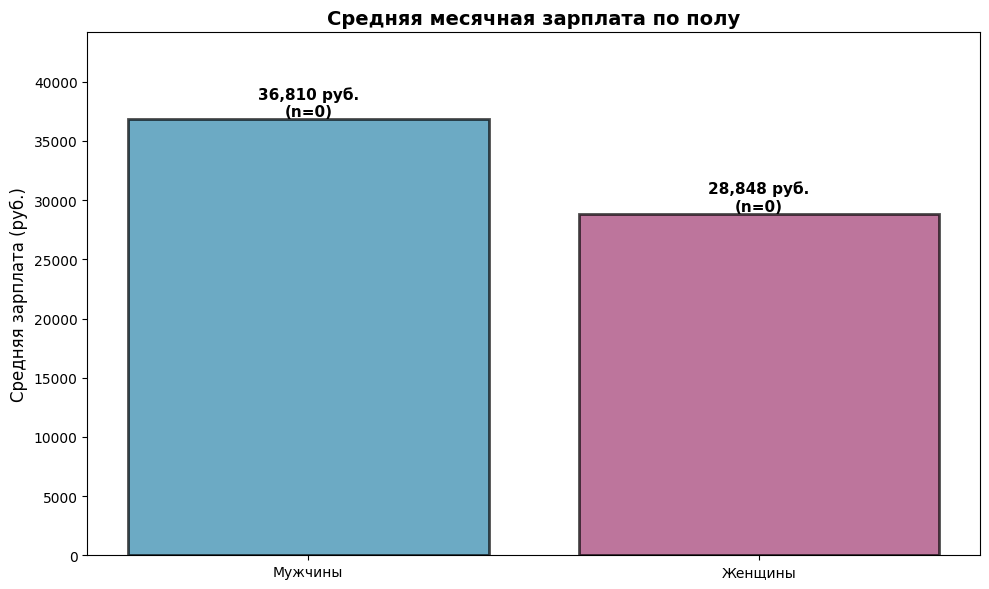

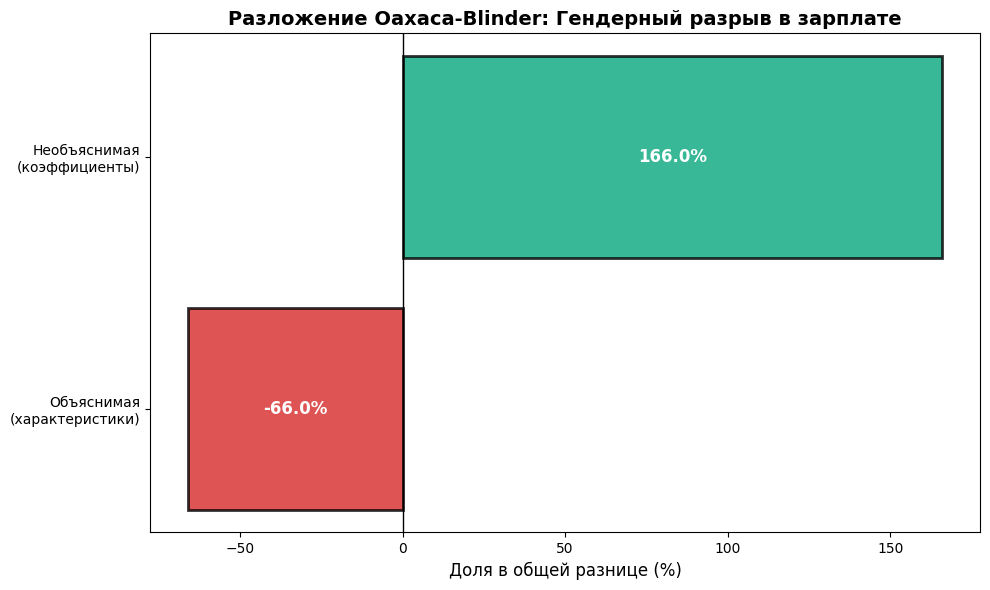

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
gender_labels = ['Males', 'Females']
gender_wages = [df_work[df_work['female']==0]['j10'].mean(),
                df_work[df_work['female']==1]['j10'].mean()]
colors = ['#2E86AB', '#A23B72']
bars = ax.bar(gender_labels, gender_wages, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Average Wage', fontsize=12)
ax.set_title('Average monthly salary by gender', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(gender_wages)*1.2)

for bar, wage in zip(bars, gender_wages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{wage:,.0f} руб.\n(n={int(bar.get_width())})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

components = ['Explicable\n(characteristics)', 'Inexplicable\n(coefficients)']
values = [explained_gap/total_gap*100, unexplained_gap/total_gap*100]
colors_decomp = ['#06A77D' if v > 0 else '#D62828' for v in values]

bars = ax.barh(components, values, color=colors_decomp, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_xlabel('Доля в общей разнице (%)', fontsize=12)
ax.set_title('Разложение Oaxaca-Blinder: Гендерный разрыв в зарплате', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Добавление значений
for bar, val in zip(bars, values):
    width = bar.get_width()
    ax.text(width/2, bar.get_y() + bar.get_height()/2.,
            f'{val:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('oaxaca_blinder_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

